# Notebook 3

## 1D differentiation

After understanding 1D convolution and smoothing in detail, we can build on top of them to understand 1D differentiation which is useful for detecting edge and motion in images. 

**Edge detection:** An edge in an image is a place where intensity changes rapidly. The edges are of interest for us because there is a rapid change in intensity. Edges result due to a variety of reasons like depth discontinuity, surface color discountinuity or illumination discontinuity. In order to detect edges, we need to differentiate the image in the horizontal or vertical direction. The differentiation is done is because the derivative is pretty large due to rapid change in intensity. 

**Image motion analysis:** Motion is detected by comparing the change in image intensity with respect to time over image space. This is an important application of computer vision softwares in real-world. 

The problem with implementing these in practice is that images are discrete values, which means that their derivatives are undefined. To fix this, we go back to understanding how images are actually obtained. 

Images are actually a sampled versions of continuous distributions of brightness. The sensor integrates the distribution of intensities over each pixel and then samples the result at pixel locations. 

### The process of differentiating an image 

Differentiating an image mathematically means that we compute the sample of the derivative of the continuous distribution of brightness values. It can be done in the following steps;

1. Undo sampling: this process is known as  *interpolation*
2. Compute the partial derivative of the continuous distribution of brightness 
3. Sample the differentiation from continuous to discrete 

Individually, these steps are difficult to implement on computer. However, when all the steps are implemented together with rather ease. 

#### Step 1: Interpolation or fitting

To bring the image from discrete to continuous domain, we  can make use of interpolation. The interpolation is actually convolution of a discrete image with a continuous kernel. 

$$C(x)  = \sum_{i=-\infty}^{i=\infty} I(i) P(x-i) $$

Here, P is the interpolation or fitting kernel. 

Using a truncated Gaussian filter is suitable here. It improves signal-noise ratio by smoothing the data, as we seen in the last notebook. 

#### Step 2: Finding the partial derivative

Then, we perform a partial differentiation

$$D(x)  = \frac{d C(x)}{d x}= \frac{d }{d x} \sum_{i=-\infty}^{i=\infty} I(i) P(x-i) $$


$$D(x)  = \sum_{i=-\infty}^{i=\infty} I(i) \frac{d P(x-i)}{d x}= \sum_{i=-\infty}^{i=\infty} I(i) P_{x}(x-i) $$

#### Step 3: Sampling the results

As the last step, we sample the partial derivative that we obtained above at the some grid point r and obtain discrete image. 

$$J(r)  = \sum_{i=-\infty}^{i=\infty} I(i) P_{x}(r-i) $$

When we reach the final step, we have nothing intermediate that makes the transition from discrete-continuous-discrete domain a hassle. 

### Implementing Image differentiation with Gaussian kernel

As discussed above, using a truncated gaussian kernel in the interpolation step is a suitable choice, let's try and implement everything using P as an unnormalized Gaussian function.

We calculate the derivative of Gaussian function g,  and then sample it over an interval [-n,n]. Then, we can normalize the one-dimensional Gaussian derivative, d using the following expressions:

$\tilde d(u)= u\exp(\frac{-u^{2}}{2\sigma^{2}})$

and normalized Gaussian kernel will be $d(u)= -k_{d}\tilde d(u)$ 

where $k_{g}$ is the normalization parameter and 

$$k_{d}=\frac{1}{\sum_{v=-n}^{n} v\tilde d(v)}$$

Using this, the output differentiated image will be:

$$J(r)  = \sum_{i=-n}^{n} I(r-i) d(i) $$

## Python implementation

Let's imagine we have a 1D image, a sin curve and we want to differentiate it using the method we have discussed above. We can find the true derivative using the np.derivative function, inbuilt in numpy and then we will formulate a function to differentiate an image using the method above. 

In [1]:
#importing required libraries 

import numpy as np
import matplotlib.pyplot as plt

In [2]:
#function to plot points as pins, taken from the course notebook

def plot_samples(values, t, name=None, pins=False):
    if pins:  
        xs = np.stack((t, t))
        ys = np.stack((np.zeros_like(values), values))
        plt.plot(xs, ys, 'r')
        plt.plot(t, values, '.r', ms=12, label=name)
    else:  
        plt.plot(t, values, label=name)

In [3]:
#function to plot signal

def plot_signal(digital_values, digital_grid, analog_values=None, analog_grid=None, title=None,
                start=None, stop=None):
    a = start if start is not None else np.min(digital_grid)
    b = stop if stop is not None else np.max(digital_grid)
    plt.figure(figsize=(12, 3), tight_layout=True)
    plt.plot([a, b], [0., 0.], 'k')
    for values, grid, discrete in ((analog_values, analog_grid, False),
                                   (digital_values, digital_grid, True)):
        if values is not None and grid is not None:
            valid = (grid >= a) & (grid <= b)
            valid_grid, valid_values = grid[valid], values[valid]
            plot_samples(valid_values, valid_grid, pins=discrete)
    valid = (digital_grid >= a) & (digital_grid <= b)
    plt.xticks(digital_grid[valid])
    if title is not None:
        plt.title(title)
    plt.show()

In [4]:
#creating a signal using the sine function inubuilt in numpy 

x= np.arange(0,np.pi,0.1)
signal=np.sin(x)

#calculating true derivative using np.gradient 

true_derivative=np.gradient(signal)

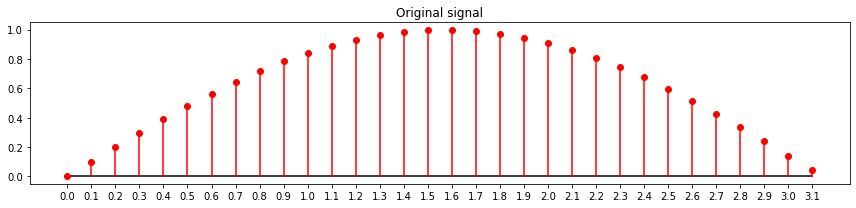

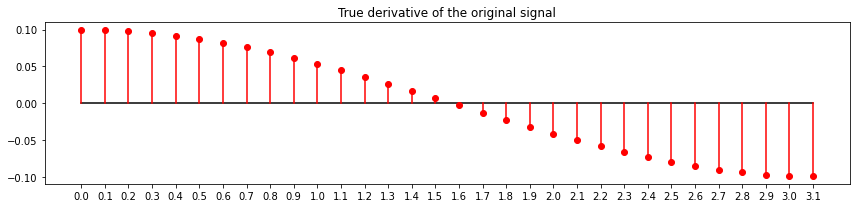

In [5]:
plot_signal(signal, x, title='Original signal')
plot_signal(true_derivative, x,
            title='True derivative of the original signal')

In [1]:
#function to create a normalized Gaussian kernel

def gauss(size, sigma):
    
    """
    Creates a Normalized 1D differentiated Gaussian kernel that can be convolved 
    with signal to get the differented image. The normalization will 
    ensure that derivatives are not scaled up or down. 
    
    Parameters
    ----------
    size,sigma : integers
        size of output differentiated Gaussian kernel using sigma value provided
    
    Returns
    -------
    g : ndarray
        normalized, differentiated Gaussian kernel
    
    Examples
    --------
    >>> gauss(5,3)
    array([ 0.19299951,  0.11400099, -0. , -0.11400099, -0.19299951])
    >>> gauss(9,3)
    array([ 0.05080013,  0.05621062,  0.04947257,  0.02922247, -0.,
       -0.02922247, -0.04947257, -0.05621062, -0.05080013])
    
    """

    x = np.mgrid[-size//2 + 1:size//2 + 1]
    g = x*(np.exp(- 0.5 * (x / sigma) ** 2))
    return g/np.sum(-x*g)

In [7]:
gaussian_kernel=gauss(15,3)
gaussian_kernel

array([ 0.00753964,  0.01330641,  0.02043063,  0.02694753,  0.02981759,
        0.02624331,  0.01550141, -0.        , -0.01550141, -0.02624331,
       -0.02981759, -0.02694753, -0.02043063, -0.01330641, -0.00753964])

### Probing with a ramp function 

We will use a ramp function to probe if the gaussian kernel on convolution with a ramp function is giving an output close to 1. 

A ramp function is represented by u(x)=x, so its derivative in the x direction will be 1. Convolving this with our Gaussian kernel will give us a surity that our kernel is working as desired. This is also a way to check that our Gaussian kernel is normalized. 

In [8]:
#defining a ramp function and convolving with the gaussian kernel to see if the output is 1

ramp = np.linspace(0., len(gaussian_kernel),  num=len(gaussian_kernel), endpoint=False)
print(np.convolve(ramp, gaussian_kernel, mode='valid')[0])

1.0000000000000002


Now, since we have confirmed with our probing function that our gaussian kernel is normalized and working as expected, let's cnvolve it with our original signal and compute the derivative

In [9]:
gaussian_derivative=np.convolve(signal,gaussian_kernel, 'same')

In [10]:
difference=gaussian_derivative-true_derivative

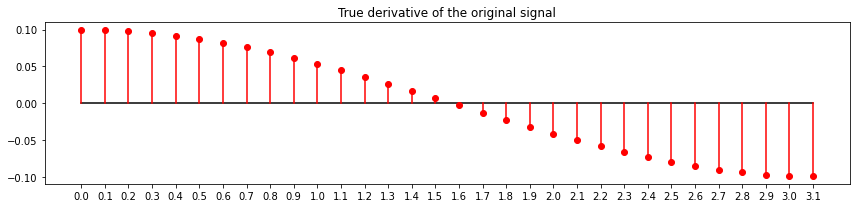

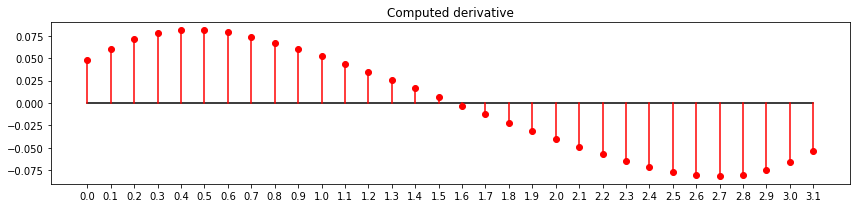

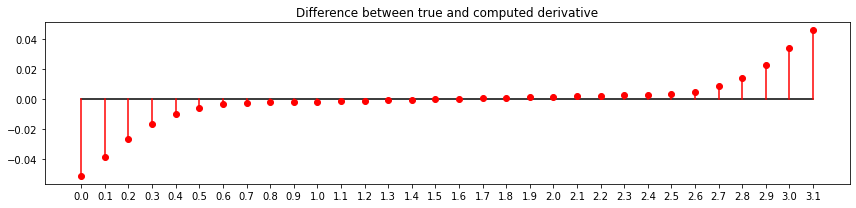

In [11]:
plot_signal(true_derivative, x,
            title='True derivative of the original signal')
plot_signal(gaussian_derivative, x, title='Computed derivative')
plot_signal(difference, x,
            title='Difference between true and computed derivative')

The error here is pretty low which indicate a successful attempt at finding derivative using a Gaussian kernel. Let's try another example using a function $y^{2}$

In [12]:
y= np.arange(0,1,0.05)
signal_y=y**2

#calculating true derivative using np.gradient 

true_derivative_y=np.gradient(signal_y)

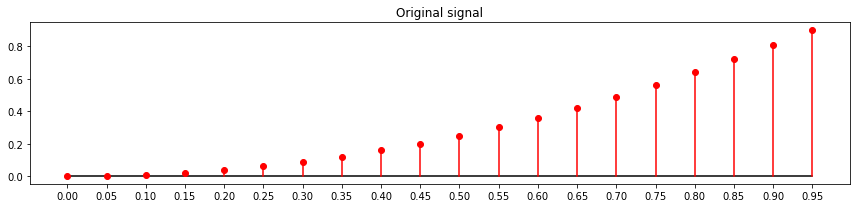

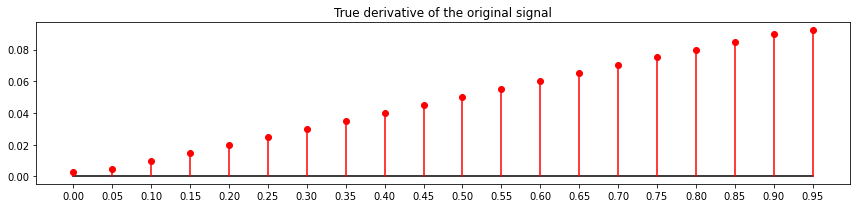

In [13]:
plot_signal(signal_y, y, title='Original signal')
plot_signal(true_derivative_y, y,
            title='True derivative of the original signal')

In [14]:
#creating a gaussian kernel of size 9 and sigma 2.5

gaussian_kernel_y=gauss(9,2.5)
gaussian_kernel_y

array([ 0.04393388,  0.05768538,  0.05737098,  0.0364664 , -0.        ,
       -0.0364664 , -0.05737098, -0.05768538, -0.04393388])

In [15]:
#probing with ramp function

ramp_y = np.linspace(0., len(gaussian_kernel_y),  num=len(gaussian_kernel_y), endpoint=False)
print(np.convolve(ramp_y, gaussian_kernel_y, mode='valid')[0])

1.0


In [16]:
gaussian_derivative_y=np.convolve(signal_y,gaussian_kernel_y, 'same')

In [17]:
difference_y=gaussian_derivative_y-true_derivative_y

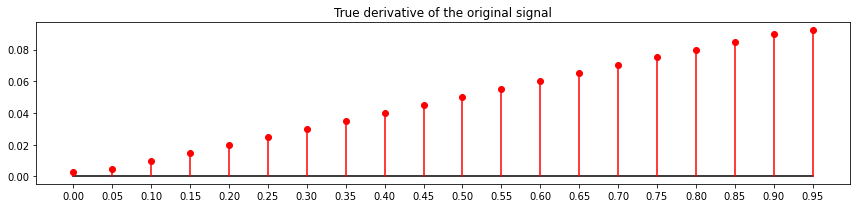

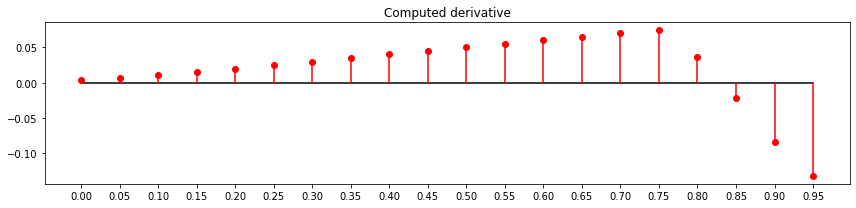

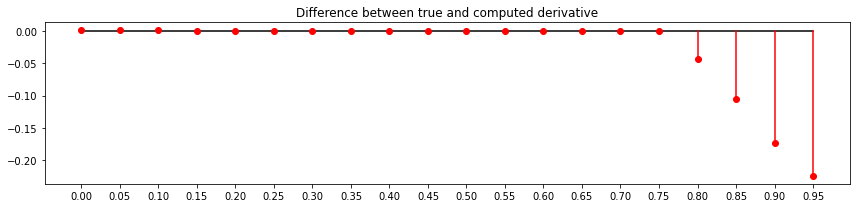

In [18]:
plot_signal(true_derivative_y, y,
            title='True derivative of the original signal')
plot_signal(gaussian_derivative_y, y, title='Computed derivative')
plot_signal(difference_y, y,
            title='Difference between true and computed derivative')

The difference grows substantially towards the end perhaps because of the nature of Gaussian kernel as it takes an average of neighbouring values. The quadratic function increases enormously as the values grow, a sharp increase in the signal which is not accounted for by the Gaussian kernel because of averaging. 

### References

1. Duke University CS 527 Spring 2022: https://courses.cs.duke.edu//spring22/compsci527/notes/n_02_differentiation.pdf
        
        
2. Carnegie Mellon University 16-385 Computer Vision: https://www.cs.cmu.edu/~16385/s17/Slides/4.0_Image_Gradients_and_Gradient_Filtering.pdf